### INEGI-GCIM Human Settlement Detection Challenge by ITU
* Can you enhance training data for vegetation mapping
* The primary objective of this challenge is to propose and develop a robust and accurate machine learning model that can help to clean and improve training data, either identifying outliers (wrong or suspicious labels), or even suggesting a more plausible label in the given test data.
* The primary objective of this challenge is to propose and develop a robust and accurate machine learning model that can help to clean and improve training data, either identifying outliers (wrong or suspicious labels), or even suggesting a more plausible label in the given test data.
* The evaluation metric for this challenge is the logloss


In [1]:
!pip install catboost --quiet

In [2]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import catboost as catt
from sklearn.metrics import log_loss

from sklearn.ensemble import IsolationForest

In [3]:

train = pd.read_csv("/kaggle/input/vegetation-mapping/Train.csv")
test = pd.read_csv("/kaggle/input/vegetation-mapping/Test.csv")
sub = pd.read_csv("/kaggle/input/vegetation-mapping/SampleSubmission.csv")
display(train.head(), test.head(), sub.head())

,id,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,PCA3,NDVI1,NDVI2,NDVI3,NDVI4,ELEV1,PEND1,ILUM1,TOPOIND1,ROUGH1,TRI1,COFS1,TMPMAN1,TMPMAX1,TMPMIN1,TVARDAY1,PRECIPAN1,PRECIPWET1,PRECIPDRY1,PRECIPVAR1,MARTONNE1,LAT2,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1,Target
0,id_0taivml7ol,231.0,251.0,496.0,464.0,2557.0,2035.0,1051.0,15578.91895,672.583374,565.505066,0.562368,0.681453,0.763305,0.067587,2014.0,28.844036,199.0,1.875,42.0,12.375,33.0,15.675409,25.320597,4.350704,13.876810,1623.614990,390.804352,2.999952,116.944008,63.238083,20.284925,-104.869507,17.0,0.174004,0.038816,0.222946,0.145658,0.036469,0.250200,-0.608060,0.318859,80
1,id_croxu0xdq9,345.0,402.0,805.0,805.0,2997.0,2443.0,1434.0,16403.79688,900.683044,516.083557,0.253720,0.546519,0.869048,0.253607,656.0,16.630325,185.0,-2.000,24.0,7.750,19.0,23.944405,35.669025,10.929708,16.047564,949.864319,257.712494,2.000000,117.124428,27.983301,20.937754,-104.551094,6.0,0.239050,0.055795,0.233304,0.130232,0.035914,0.275557,-0.504310,0.260253,39
2,id_qfv0klgl9b,413.0,518.0,775.0,1022.0,2936.0,3266.0,2351.0,17203.26953,1275.056519,-325.276093,0.251043,0.479669,0.908817,0.235585,1543.0,3.821051,181.0,0.375,4.0,1.875,22.0,17.999048,31.231258,3.986085,17.208784,1030.634766,238.203903,5.000000,104.941284,36.809792,20.285265,-104.509377,0.0,0.114193,0.028076,0.245645,0.041095,0.007986,0.193860,-0.616432,0.162898,26
3,id_mlubcnl27r,196.0,295.0,806.0,675.0,2964.0,2249.0,1260.0,16105.81738,900.010620,637.292908,0.178295,0.539449,0.860523,0.257632,82.0,1.312327,183.0,0.625,1.0,0.625,21.0,25.381269,33.802109,14.417583,12.934464,1475.699097,367.842773,2.000000,121.767151,41.708473,20.930613,-105.037415,0.0,0.177530,0.057263,0.322373,0.069336,0.008118,0.116911,-0.472340,0.281847,96
4,id_rej7e1nz2p,366.0,404.0,697.0,803.0,2479.0,2722.0,1794.0,16414.72266,822.154480,-137.591675,0.302760,0.490486,0.728987,0.148521,1906.0,5.921676,193.0,-1.875,5.0,1.875,33.0,16.311563,28.353050,3.717713,15.805076,1248.408325,289.702484,4.976198,107.161186,47.448189,20.153313,-104.504051,0.0,0.153453,0.035333,0.230104,0.104264,0.022265,0.213336,-0.592278,0.205492,98


,id,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,PCA3,NDVI1,NDVI2,NDVI3,NDVI4,ELEV1,PEND1,ILUM1,TOPOIND1,ROUGH1,TRI1,COFS1,TMPMAN1,TMPMAX1,TMPMIN1,TVARDAY1,PRECIPAN1,PRECIPWET1,PRECIPDRY1,PRECIPVAR1,MARTONNE1,LAT2,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1
0,id_utdshhcma9,125.0,174.0,429.0,365.0,3449.0,1819.0,874.0,15658.46289,1138.856689,1342.518311,0.707215,0.806182,0.904407,0.076291,12.0,1.312327,178.0,-0.375,3.0,0.875,25.0,25.690691,33.658134,14.699665,12.694800,1531.758057,402.577484,2.000000,125.149086,42.917564,21.182333,-105.159805,7.0,0.180058,0.045851,0.254506,0.150816,0.035861,0.237626,-0.618327,0.350910
1,id_wpr03x91k8,110.0,129.0,363.0,193.0,3113.0,1265.0,485.0,15037.56445,714.649597,1538.093018,0.834036,0.881114,0.920911,0.034153,338.0,23.752207,162.0,1.000,31.0,11.125,29.0,24.453812,32.278534,13.702362,12.552006,1447.593018,387.342896,1.000000,126.379227,42.015106,21.466331,-105.162437,24.0,0.258292,0.058265,0.225489,0.227427,0.071647,0.314893,-0.554054,0.445714
2,id_ihn04pau10,141.0,159.0,338.0,312.0,2013.0,1228.0,600.0,14677.36621,80.350555,710.388794,0.686321,0.742191,0.824526,0.044589,1798.0,28.301126,99.0,0.000,48.0,12.625,39.0,17.929491,29.942381,5.258607,16.334858,1274.724609,323.231262,3.730577,115.144913,45.643742,21.449936,-104.746994,26.0,0.170567,0.046422,0.272002,0.159551,0.042044,0.263349,-0.568327,0.343545
3,id_dujctwctkv,247.0,109.0,368.0,222.0,3613.0,1747.0,755.0,15594.74512,1190.041992,1586.436035,0.782598,0.878006,0.944320,0.053685,48.0,2.074427,176.0,0.625,3.0,0.875,23.0,25.650383,33.777676,14.476235,13.191067,1376.053223,342.328552,1.892010,121.635658,38.598583,20.867746,-105.145180,0.0,0.230309,0.063892,0.277296,0.192240,0.049381,0.256738,-0.652009,0.396483
4,id_fjf3v7c0h6,215.0,271.0,579.0,457.0,3145.0,1715.0,870.0,15646.23828,789.847656,1194.410767,0.302388,0.634091,0.840916,0.209551,1292.0,3.821051,171.0,-0.500,5.0,1.375,29.0,19.873257,31.943020,6.819028,16.256441,1238.448853,331.773071,2.363760,120.792892,41.456902,21.484732,-104.731415,0.0,0.144379,0.040683,0.281584,0.071042,0.012255,0.172266,-0.495205,0.326886


,id,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13,Target_14,Target_15,Target_16,Target_17,Target_18,Target_19,Target_20,Target_21,Target_22,Target_23,Target_24,Target_25,Target_26,Target_27,Target_28,Target_29,Target_30,Target_31,Target_32,Target_33,Target_34,Target_35,Target_36,Target_37,Target_38,Target_39,Target_40,Target_41,Target_42,Target_43,Target_44,Target_45,Target_46,Target_47,Target_48,...,Target_75,Target_76,Target_77,Target_78,Target_79,Target_80,Target_81,Target_82,Target_83,Target_84,Target_85,Target_86,Target_87,Target_88,Target_89,Target_90,Target_91,Target_92,Target_93,Target_94,Target_95,Target_96,Target_97,Target_98,Target_99,Target_100,Target_101,Target_102,Target_103,Target_104,Target_105,Target_106,Target_107,Target_108,Target_109,Target_110,Target_111,Target_112,Target_113,Target_114,Target_115,Target_116,Target_117,Target_118,Target_119,Target_120,Target_121,Target_122,Target_123,Target_124
0,id_500l32zjvv,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_yt6w9c5yk0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_vad78aaa0u,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_fwehzp3ph2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_skvctyltlp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
print(f"The train dataset has a shape of: {train.shape} and the test has a shape of: {test.shape}")
print(f"There are {train['Target'].nunique()} unique labels in the train dataset")
print(train['Target'].value_counts())

The train dataset has a shape of: (2123, 43) and the test has a shape of: (923, 42)
There are 45 unique labels in the train dataset
Target
69     153
26     144
98     119
25     115
95     106
80     101
94      90
22      89
23      85
79      81
19      79
1       78
101     78
39      71
11      66
100     61
97      60
28      52
29      50
102     46
20      45
74      42
112     37
16      34
67      27
27      23
81      23
4       22
41      21
3       18
5       14
99      11
96      11
75      11
114     11
110      8
24       8
106      8
118      4
17       4
2        4
123      4
21       4
88       3
30       2
Name: count, dtype: int64


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
REFLEC1,2123.0,254.458314,135.965915,41.000000,165.000000,229.000000,310.500000,1187.000000
REFLEC2,2123.0,299.121997,189.843372,51.000000,185.000000,249.000000,359.000000,1938.000000
REFLEC3,2123.0,563.690061,248.496908,129.000000,418.000000,502.000000,643.000000,2970.000000
REFLEC4,2123.0,541.601978,359.800824,27.000000,303.500000,431.000000,674.000000,3732.000000
REFLEC5,2123.0,2590.793688,574.675123,69.000000,2263.000000,2589.000000,2959.500000,5170.000000
REFLEC6,2123.0,1968.618464,597.535634,31.000000,1553.000000,1896.000000,2317.000000,5613.000000
REFLEC7,2123.0,1081.203486,502.598459,19.000000,700.000000,948.000000,1363.000000,3609.000000
PCA1,2123.0,15655.990204,798.301229,12963.531250,15150.290525,15550.262700,16030.361330,21658.392580
PCA2,2123.0,601.307990,463.536136,-1717.140381,373.564545,639.532715,895.429840,2169.373535
PCA3,2123.0,598.023249,544.899128,-1072.501465,209.359756,600.063965,975.081451,2500.275635


In [6]:
id_col = "id"
target_col = "Target"
continous_cols = [col for col in train.columns if col not in [id_col, target_col]]


### Cross Validation

In [7]:
# Get the value counts of the Target column
target_counts = train['Target'].value_counts()

# Filter out rows where the count of a target is less than 10
train_balanced = train[train['Target'].isin(target_counts[target_counts >= 5].index)].reset_index(drop=True)

train_imbalanced = train[~train['id'].isin(train_balanced['id'].unique())].reset_index(drop=True)
train_imbalanced.shape, train_balanced.shape, train.shape

((25, 43), (2098, 43), (2123, 43))

In [8]:
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
# Create folds
train_balanced['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(X=train_balanced, y=train_balanced['Target'])):
    train_balanced.loc[val_idx, 'fold'] = fold

train_balanced['fold'].value_counts()

fold
1    420
0    420
2    420
4    419
3    419
Name: count, dtype: int64

In [9]:
train_final = pd.concat([train_balanced, train_imbalanced]).reset_index(drop=True)
train_final['fold'] = train_final['fold'].fillna(-1)
train_final.fold.value_counts()

fold
 1.0    420
 0.0    420
 2.0    420
 4.0    419
 3.0    419
-1.0     25
Name: count, dtype: int64

### Feature Engineering

In [10]:
drop_cols = ['LAT2', 'LON1']
def feature_engineering(train, test):
    data = pd.concat([train, test])
            
    selected_columns = [col for col in data.columns if col not in drop_cols + [target_col, id_col, 'fold',]]
    
    train = data[data[id_col].isin(train[id_col].unique())]
    test = data[data[id_col].isin(test[id_col].unique())]
    
    return train, test, selected_columns
    
train_df, test_df, selected_columns = feature_engineering(train_final, test)
train_df.shape, test_df.shape


((2123, 44), (923, 44))

### Stage 1 Modelling

In [11]:
df_train = train_df[train_df['fold'] != -1]
extra = train_df[train_df['fold'] == -1]

label_encoder = LabelEncoder()
df_train[target_col] = label_encoder.fit_transform(df_train[target_col])
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label map (original -> encoded):", label_map)

fold_pred = []
oof_pred = []
n_splits = train_df['fold'].nunique() - 1
params = {
    'iterations': 500,
    'random_state': 42,
    'bootstrap_type': 'Bernoulli',
    'max_depth': 7,
    'learning_rate': 0.008436034013684798,
    'l2_leaf_reg': 0.8908564261285311,
}

oof_preds = np.zeros((len(df_train), len(label_map)))
true_labels = np.zeros(len(df_train))

for fold in range(n_splits):
    print("*" * 100)
    
    training = df_train[df_train['fold'] != fold]
    validation = df_train[df_train['fold'] == fold]
    
    y_train = training[target_col]
    y_test = validation[target_col]
    X_train = training[selected_columns]
    X_test = validation[selected_columns]
    
    model = catt.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=250)
    preds_proba = model.predict_proba(X_test)
    
    oof_preds[df_train['fold'] == fold] = preds_proba
    true_labels[df_train['fold'] == fold] = y_test
    
    loss = log_loss(y_test, preds_proba)
    print(f"LogLoss for fold {fold}: {loss}")
    oof_pred.append(loss)
    
    test_preds_proba = model.predict_proba(test_df[selected_columns])
    fold_pred.append(test_preds_proba)

average_logloss = np.mean(oof_pred)
print(f"The average logloss across the {n_splits} groups: {average_logloss}")

# Identify potentially mislabeled instances using OOF predictions
predicted_labels = np.argmax(oof_preds, axis=1)
predicted_probs = np.max(oof_preds, axis=1)

# You can adjust this threshold as needed
oof_threshold = 0.5
oof_mislabeled = (predicted_labels != true_labels) & (predicted_probs > oof_threshold)

print(f"Number of potentially mislabeled instances (OOF): {oof_mislabeled.sum()}")
print(f"Percentage of potentially mislabeled instances (OOF): {oof_mislabeled.sum() / len(df_train) * 100:.2f}%")

# Identify outliers using Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(df_train[selected_columns]) == -1

print(f"Number of potential outliers (Isolation Forest): {outliers.sum()}")
print(f"Percentage of potential outliers (Isolation Forest): {outliers.sum() / len(df_train) * 100:.2f}%")

# Combine OOF and Isolation Forest results
combined_mislabeled = oof_mislabeled | outliers

print(f"Number of potentially mislabeled instances (Combined): {combined_mislabeled.sum()}")
print(f"Percentage of potentially mislabeled instances (Combined): {combined_mislabeled.sum() / len(df_train) * 100:.2f}%")

# Create a clean dataset
clean_df = df_train[~combined_mislabeled]

print(f"Shape of original dataset: {df_train.shape}")
print(f"Shape of cleaned dataset: {clean_df.shape}")



Label map (original -> encoded): {1.0: 0, 3.0: 1, 4.0: 2, 5.0: 3, 11.0: 4, 16.0: 5, 19.0: 6, 20.0: 7, 22.0: 8, 23.0: 9, 24.0: 10, 25.0: 11, 26.0: 12, 27.0: 13, 28.0: 14, 29.0: 15, 39.0: 16, 41.0: 17, 67.0: 18, 69.0: 19, 74.0: 20, 75.0: 21, 79.0: 22, 80.0: 23, 81.0: 24, 94.0: 25, 95.0: 26, 96.0: 27, 97.0: 28, 98.0: 29, 99.0: 30, 100.0: 31, 101.0: 32, 102.0: 33, 106.0: 34, 110.0: 35, 112.0: 36, 114.0: 37}
****************************************************************************************************
0:	learn: 3.6300287	test: 3.6343119	best: 3.6343119 (0)	total: 419ms	remaining: 3m 29s
250:	learn: 2.6242804	test: 3.2953282	best: 3.2953282 (250)	total: 1m 5s	remaining: 1m 5s
499:	learn: 2.0483318	test: 3.2565096	best: 3.2562289 (497)	total: 2m 10s	remaining: 0us

bestTest = 3.256228889
bestIteration = 497

Shrink model to first 498 iterations.
LogLoss for fold 0: 3.2562288893687406
****************************************************************************************************
0:	

### Cross Validation with the clean dataset

In [12]:
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
# Create folds
clean_df = clean_df.reset_index(drop=True)
clean_df['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(X=clean_df, y=clean_df['Target'])):
    clean_df.loc[val_idx, 'fold'] = fold

clean_df['fold'].value_counts()

fold
2    378
1    378
0    378
4    377
3    377
Name: count, dtype: int64

### Catboost with cleaned train dataset

In [13]:
fold_pred = []
oof_pred = []
n_splits = 5
params = {'depth': 4, 'learning_rate': 0.022161851584160647, 'l2_leaf_reg': 2.212186606298941e-06, 'iterations': 273, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.6242406152677233}
selected_columns = [col for col in clean_df.columns if col not in drop_cols + [target_col, id_col, 'fold','DOSEL1','PCA1', 'PCA2', 'PCA3','VHVVD1', 'MNDWI1', 'NDTI1', 'VHVVR1', 'VVD1', 'VHD1', 
                                                                              'VVR1', 'VHR1','ILUM1']]
params_2 = {'depth': 4, 'learning_rate': 0.03524575821224079, 'l2_leaf_reg': 1.2978043680220617, 'iterations': 379, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.263658755075727}
for fold in range(n_splits):
    print("*" * 100)
    
    training = clean_df[clean_df['fold'] != fold]
    validation = clean_df[clean_df['fold'] == fold]
    
    y_train = training[target_col]
    y_test = validation[target_col]

    X_train = training[selected_columns]
    X_test = validation[selected_columns]
    
    model = catt.CatBoostClassifier(**params_2, verbose= 250,random_state= 42,)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=250)
    
    preds_proba = model.predict_proba(X_test)
    
    loss = log_loss(y_test, preds_proba)
    print(f"LogLoss for fold {fold}: {loss}")
    oof_pred.append(loss)
    

    test_preds_proba = model.predict_proba(test_df[selected_columns])
    fold_pred.append(test_preds_proba)

average_logloss = np.mean(oof_pred)
print(f"The average logloss across the {n_splits} groups: {average_logloss}")

****************************************************************************************************
0:	learn: 3.6174558	test: 3.6199796	best: 3.6199796 (0)	total: 55.7ms	remaining: 21.1s
250:	learn: 2.6492789	test: 3.2830926	best: 3.2692890 (150)	total: 7.27s	remaining: 3.71s
378:	learn: 2.4068553	test: 3.3093827	best: 3.2692890 (150)	total: 10.9s	remaining: 0us

bestTest = 3.269289028
bestIteration = 150

Shrink model to first 151 iterations.
LogLoss for fold 0: 3.2692890283440805
****************************************************************************************************
0:	learn: 3.6160172	test: 3.6184422	best: 3.6184422 (0)	total: 40.7ms	remaining: 15.4s
250:	learn: 2.6349442	test: 3.3235375	best: 3.3092437 (158)	total: 7.18s	remaining: 3.66s
378:	learn: 2.4024669	test: 3.3536809	best: 3.3092437 (158)	total: 10.9s	remaining: 0us

bestTest = 3.309243741
bestIteration = 158

Shrink model to first 159 iterations.
LogLoss for fold 1: 3.309243741303615
*************************

### Feature Importance

Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

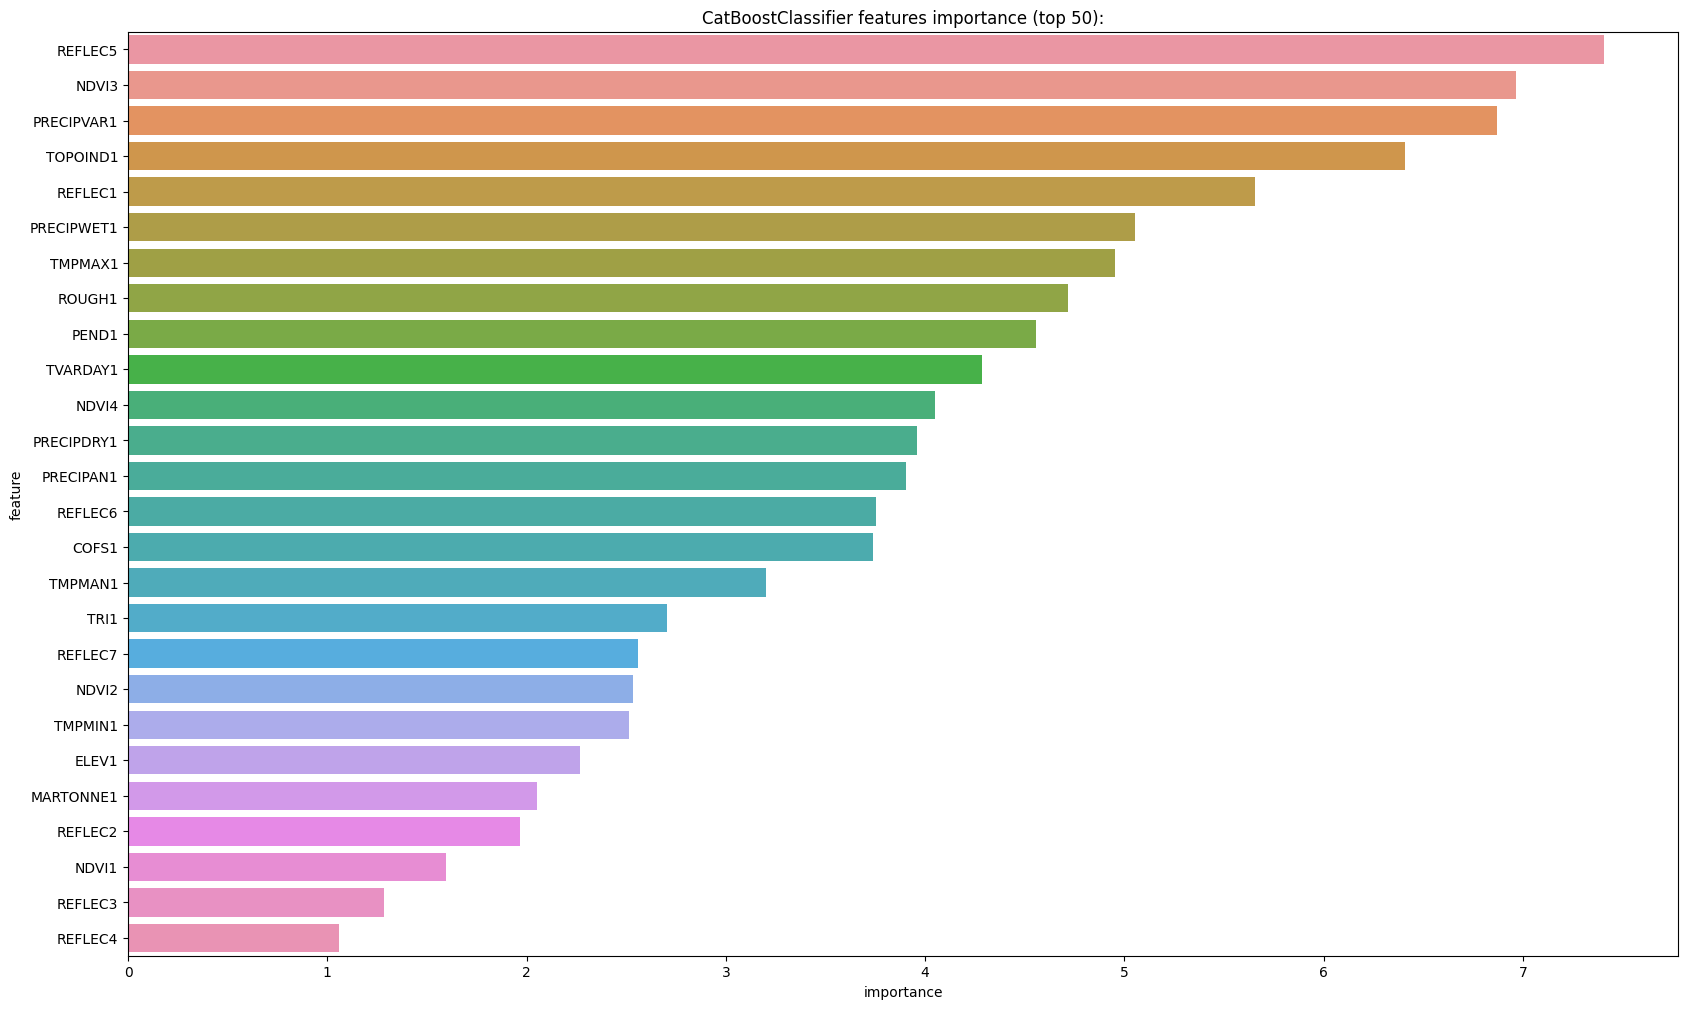

In [14]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = selected_columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')


In [15]:

fold_pred = np.array(fold_pred)
final_test_pred = np.mean(fold_pred, axis=0)

class_labels = label_encoder.inverse_transform(np.arange(final_test_pred.shape[1]))
class_labels

array([  1.,   3.,   4.,   5.,  11.,  16.,  19.,  20.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  39.,  41.,  67.,  69.,  74.,  75.,
        79.,  80.,  81.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 106., 110., 112., 114.])

In [16]:
submission_df = pd.DataFrame(final_test_pred, columns=[f'Target_{int(cls)}' for cls in class_labels])
submission_df['id'] = test_df['id']
submission_df = submission_df[['id'] + [f'Target_{int(cls)}' for cls in class_labels]]
required_columns = [f'Target_{i}' for i in range(125)]
missing_columns = set(required_columns) - set(submission_df.columns)

#fill the missing classes in train with a value not 0 as 0 assumes you have high probability of its absence 
for col in missing_columns:
    submission_df[col] = 0.00055
    
submission_df = submission_df[['id'] + required_columns]
submission_df.head()

,id,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13,Target_14,Target_15,Target_16,Target_17,Target_18,Target_19,Target_20,Target_21,Target_22,Target_23,Target_24,Target_25,Target_26,Target_27,Target_28,Target_29,Target_30,Target_31,Target_32,Target_33,Target_34,Target_35,Target_36,Target_37,Target_38,Target_39,Target_40,Target_41,Target_42,Target_43,Target_44,Target_45,Target_46,Target_47,Target_48,...,Target_75,Target_76,Target_77,Target_78,Target_79,Target_80,Target_81,Target_82,Target_83,Target_84,Target_85,Target_86,Target_87,Target_88,Target_89,Target_90,Target_91,Target_92,Target_93,Target_94,Target_95,Target_96,Target_97,Target_98,Target_99,Target_100,Target_101,Target_102,Target_103,Target_104,Target_105,Target_106,Target_107,Target_108,Target_109,Target_110,Target_111,Target_112,Target_113,Target_114,Target_115,Target_116,Target_117,Target_118,Target_119,Target_120,Target_121,Target_122,Target_123,Target_124
0,id_utdshhcma9,0.00055,0.038585,0.00055,0.006567,0.013576,0.006286,0.00055,0.00055,0.00055,0.00055,0.00055,0.044073,0.00055,0.00055,0.00055,0.00055,0.015314,0.00055,0.00055,0.017925,0.014239,0.00055,0.015396,0.036368,0.004813,0.040274,0.029129,0.005564,0.020225,0.015341,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.029298,0.00055,0.009741,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,...,0.015631,0.00055,0.00055,0.00055,0.051143,0.025637,0.005217,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.038182,0.060814,0.011907,0.013157,0.046310,0.005417,0.178125,0.035909,0.016386,0.00055,0.00055,0.00055,0.012057,0.00055,0.00055,0.00055,0.006011,0.00055,0.033579,0.00055,0.005440,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055
1,id_wpr03x91k8,0.00055,0.017416,0.00055,0.006135,0.013500,0.009413,0.00055,0.00055,0.00055,0.00055,0.00055,0.031027,0.00055,0.00055,0.00055,0.00055,0.034043,0.00055,0.00055,0.035674,0.013573,0.00055,0.030346,0.023032,0.006425,0.035809,0.026696,0.004648,0.018162,0.018528,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.020804,0.00055,0.017499,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,...,0.006410,0.00055,0.00055,0.00055,0.029034,0.037764,0.007740,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.085780,0.092607,0.006911,0.021527,0.049451,0.007603,0.052907,0.039827,0.017633,0.00055,0.00055,0.00055,0.004764,0.00055,0.00055,0.00055,0.003868,0.00055,0.103379,0.00055,0.009080,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055
2,id_ihn04pau10,0.00055,0.023006,0.00055,0.005416,0.011531,0.006162,0.00055,0.00055,0.00055,0.00055,0.00055,0.013956,0.00055,0.00055,0.00055,0.00055,0.026462,0.00055,0.00055,0.074111,0.033821,0.00055,0.082624,0.045311,0.004683,0.074085,0.071152,0.007384,0.025223,0.053597,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.013158,0.00055,0.009376,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,...,0.002172,0.00055,0.00055,0.00055,0.044039,0.054215,0.011688,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.042000,0.033250,0.002507,0.025531,0.053622,0.004413,0.010571,0.034265,0.015058,0.00055,0.00055,0.00055,0.002374,0.00055,0.00055,0.00055,0.004030,0.00055,0.012710,0.00055,0.004952,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055
3,id_dujctwctkv,0.00055,0.046866,0.00055,0.010195,0.023083,0.009677,0.00055,0.00055,0.00055,0.00055,0.00055,0.053112,0.00055,0.00055,0.00055,0.00055,0.018906,0.00055,0.00055,0.019512,0.018297,0.00055,0.020187,0.030688,0.006828,0.038501,0.040767,0.006441,0.024703,0.019879,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.034047,0.00055,0.008454,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,0.00055,...,0.018371,0.00055

In [18]:
submission_df.to_csv("catboost_final_inegi.csv", index=False)